In [ ]:
import tarfile
import numpy as np
import torch
from torch.utils.data import Dataset
from io import BytesIO
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import copy

In [ ]:

# Extract the tar file
with tarfile.open("HEP1_jets.tar", "r") as tar:
    tar.extractall("HEP1_jets_extracted")  # or just "." to extract here

In [ ]:
import tarfile
import numpy as np
import torch
from torch.utils.data import Dataset
from io import BytesIO
import zipfile  # For catching bad zip files

class JetEventDataset(Dataset):
    def __init__(self, tar_path):
        self.samples = []
        print(f"Opening tar file: {tar_path}")

        with tarfile.open(tar_path, "r") as tar:
            npz_members = [m for m in tar.getmembers() if m.name.endswith(".npz")]
            # No max_files slicing here, load all npz files found

            for member in npz_members:
                file_obj = tar.extractfile(member)
                if file_obj is None:
                    continue
                try:
                    with np.load(BytesIO(file_obj.read())) as data:
                        if 'x' in data and 'y' in data:
                            X = data['x']  # shape (n, 5)
                            Y = data['y']  # shape (5,)
                            self.samples.append((X, Y))
                except zipfile.BadZipFile:
                    print(f"Skipping invalid NPZ file: {member.name}")
                    continue
                except Exception as e:
                    print(f"An error occurred while processing {member.name}: {e}")
                    continue

        if not self.samples:
            print("No valid samples found in the tar file.")
            self.x_mean = np.zeros(5)
            self.x_std = np.ones(5)
        else:
            all_x = np.concatenate([x for x, y in self.samples], axis=0)
            self.x_mean = all_x.mean(axis=0)
            self.x_std = all_x.std(axis=0)
            self.x_std[self.x_std == 0] = 1e-6
            print(f"Computed mean: {self.x_mean}, std: {self.x_std}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]  # x.shape = (n_particles, 5)
        x = x.copy()  # avoid modifying original data
        pt_idx, eta_idx, phi_idx = 0, 1, 2  # feature indices

        # Normalize pt by sum of pt within the jet
        pt_sum = x[:, pt_idx].sum()
        if pt_sum > 0:
            x[:, pt_idx] /= pt_sum

        # Center eta and phi within the jet
        for angle_idx in [eta_idx, phi_idx]:
            angle_mean = x[:, angle_idx].mean()
            x[:, angle_idx] -= angle_mean

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)



In [ ]:
dataset = JetEventDataset("HEP1_jets.tar")

Opening tar file: HEP1_jets.tar
Skipping invalid NPZ file: jets/event_0754772.npz
Computed mean: [ 0.01931338  0.00015545 -0.07467682  0.01926739  0.13583133], std: [0.04292625 0.1148214  0.1427562  0.04282288 0.11183869]


# Model Stuff


In [ ]:
import torch
import torch.nn as nn

class DeepSetClassifier(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=128, output_dim=5):
        super().__init__()

        # φ (phi): Element-wise network
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # ρ (rho): Aggregation network
        self.rho = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)  # Output logits for CrossEntropyLoss
        )

    def forward(self, x, batch_idx):
        """
        x: Tensor of shape [sum(n_i), 5]
        batch_idx: Tensor of shape [sum(n_i)] with integers [0, batch_size-1]
        """
        x_phi = self.phi(x)  # shape [sum(n_i), hidden_dim]

        # Aggregate with mean over each set
        batch_size = batch_idx.max().item() + 1
        pooled = torch.zeros(batch_size, x_phi.size(-1), device=x.device)
        pooled.index_add_(0, batch_idx, x_phi)

        # Normalize (mean over counts)
        counts = torch.bincount(batch_idx, minlength=batch_size).float().unsqueeze(1)
        pooled = pooled / counts

        out = self.rho(pooled)  # shape [batch_size, output_dim]
        return out

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# -------- Assume X_y_pairs is already created --------
# X_y_pairs: list of tuples (x_i, y_i)
# x_i: tensor of shape [n_i, 5], variable-length
# y_i: tensor of shape [5], one-hot

# -------- Split into X and y --------
X, y = zip(*dataset)  # X: tuple of tensors [n_i, 5], y: tuple of tensors [5]
X = list(X)
y = torch.stack(y)  # shape [N, 5]

# -------- Normalize each feature across all x_i --------
all_data = torch.cat(X, dim=0)  # shape [sum(n_i), 5]
mean = all_data.mean(dim=0)
std = all_data.std(dim=0)
std[std == 0] = 1.0  # avoid divide by zero

X = [(x - mean) / std for x in X]

# -------- Dataset class --------
class SetDataset(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -------- Split dataset --------
dataset = SetDataset(X, y)
total_len = len(dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len

train_set, val_set, test_set = random_split(
    dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

# -------- Collate function --------
def collate_fn(batch):
    sets, labels = zip(*batch)
    return list(sets), torch.stack(labels)

# -------- DataLoaders --------
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
# Define model and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = DeepSetClassifier().to(device)



# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # weight decay = L2 regularization

# Learning rate scheduler: reduces LR by gamma every step_size epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Tracking lists
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 100
best_val_loss = float('inf')
patience = 10


Using device: cuda


In [ ]:


for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = [x.to(device) for x in inputs]
        labels = labels.to(device)

        x = torch.cat(inputs, dim=0)
        batch_idx = torch.cat([
            torch.full((sample.size(0),), i, dtype=torch.long)
            for i, sample in enumerate(inputs)
        ]).to(device)

        optimizer.zero_grad()
        outputs = model(x, batch_idx)

        labels_idx = torch.argmax(labels, dim=1)
        loss = criterion(outputs, labels_idx)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels_idx).item()
        total_samples += labels.size(0)

    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = running_corrects / total_samples

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = [x.to(device) for x in inputs]
            labels = labels.to(device)

            x = torch.cat(inputs, dim=0)
            batch_idx = torch.cat([
                torch.full((sample.size(0),), i, dtype=torch.long)
                for i, sample in enumerate(inputs)
            ]).to(device)

            outputs = model(x, batch_idx)

            labels_idx = torch.argmax(labels, dim=1)
            loss = criterion(outputs, labels_idx)

            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels_idx).item()
            val_samples += labels.size(0)

    epoch_val_loss = val_loss / val_samples
    epoch_val_acc = val_corrects / val_samples

    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(epoch_val_loss)
    else:
        scheduler.step()

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_wts)


Epoch 1/100
Train Loss: 1.2983 Acc: 0.4364 | Val Loss: 1.1551 Acc: 0.4694
Epoch 2/100
Train Loss: 1.0216 Acc: 0.5925 | Val Loss: 1.0096 Acc: 0.5932
Epoch 3/100
Train Loss: 0.9548 Acc: 0.6245 | Val Loss: 0.9684 Acc: 0.6141
Epoch 4/100
Train Loss: 0.9340 Acc: 0.6323 | Val Loss: 0.9383 Acc: 0.6415
Epoch 5/100
Train Loss: 0.9084 Acc: 0.6456 | Val Loss: 0.9321 Acc: 0.6415
Epoch 6/100
Train Loss: 0.8959 Acc: 0.6536 | Val Loss: 0.9190 Acc: 0.6467
Epoch 7/100
Train Loss: 0.8740 Acc: 0.6691 | Val Loss: 0.8945 Acc: 0.6662
Epoch 8/100
Train Loss: 0.8674 Acc: 0.6669 | Val Loss: 0.8702 Acc: 0.6767
Epoch 9/100
Train Loss: 0.8408 Acc: 0.6879 | Val Loss: 0.8575 Acc: 0.6871
Epoch 10/100
Train Loss: 0.8374 Acc: 0.6902 | Val Loss: 0.8687 Acc: 0.6936
No improvement for 1 epochs.
Epoch 11/100
Train Loss: 0.7965 Acc: 0.7119 | Val Loss: 0.8182 Acc: 0.7066
Epoch 12/100
Train Loss: 0.7956 Acc: 0.7132 | Val Loss: 0.8223 Acc: 0.7066
No improvement for 1 epochs.
Epoch 13/100
Train Loss: 0.7901 Acc: 0.7081 | Val L

<All keys matched successfully>

In [ ]:
model.eval()
test_loss = 0.0
test_corrects = 0
test_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = [x.to(device) for x in inputs]
        labels = labels.to(device)

        x = torch.cat(inputs, dim=0)
        batch_idx = torch.cat([
            torch.full((sample.size(0),), i, dtype=torch.long)
            for i, sample in enumerate(inputs)
        ]).to(device)

        outputs = model(x, batch_idx)

        labels_idx = torch.argmax(labels, dim=1)
        loss = criterion(outputs, labels_idx)

        test_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels_idx).item()
        test_samples += labels.size(0)

final_test_loss = test_loss / test_samples
final_test_acc = test_corrects / test_samples

print(f"Test Loss: {final_test_loss:.4f} | Test Accuracy: {final_test_acc:.4f}")



Test Loss: 0.6634 | Test Accuracy: 0.7750


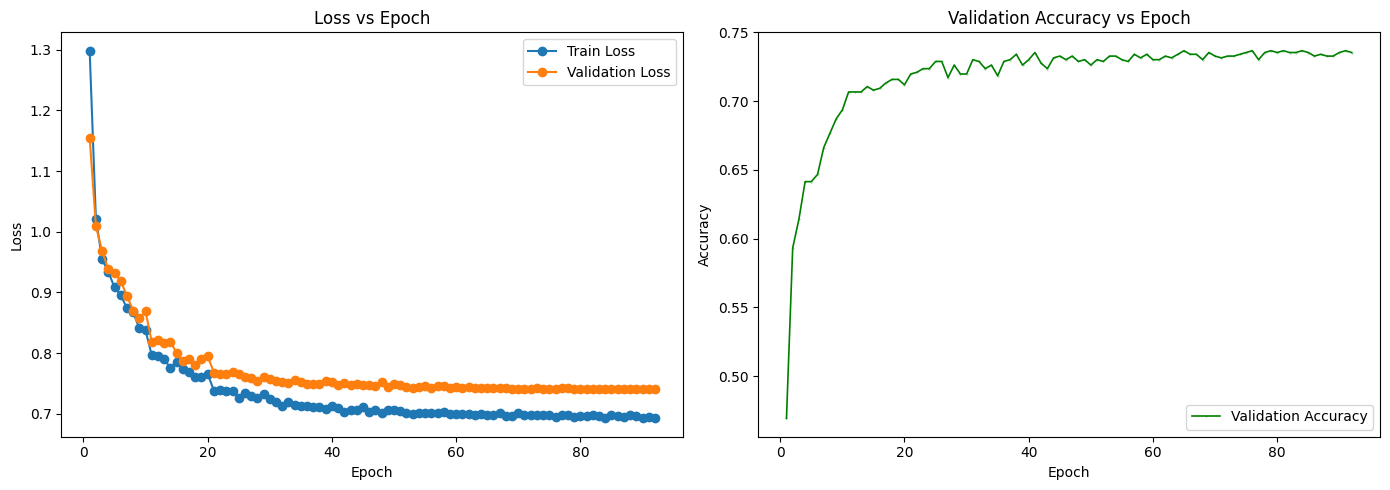

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(False)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green', linewidth = 1.2, markersize = 0.2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()


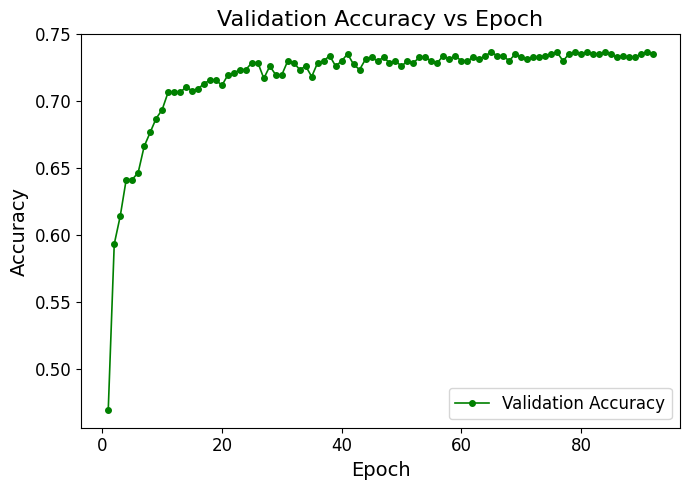

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot and save only the Validation Accuracy subplot
plt.figure(figsize=(7, 5))
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green', linewidth=1.2, markersize=4)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Validation Accuracy vs Epoch', fontsize=16)
plt.legend(fontsize=12)
plt.grid(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("val_accuracy_plot.png", dpi=300)
plt.show()



In [ ]:
import torch
from collections import defaultdict
from tqdm import tqdm
model.eval()
test_results = []

with torch.no_grad():
    for sets, labels in test_loader:
        # Flatten and index each set in the batch
        batch_x = torch.cat(sets, dim=0).to(device)
        batch_idx = torch.cat([torch.full((len(s),), i, dtype=torch.long) for i, s in enumerate(sets)]).to(device)

        # Move labels to device
        labels = labels.to(device)

        # Forward pass
        logits = model(batch_x, batch_idx)

        # Convert to predictions (one-hot)
        preds = torch.nn.functional.one_hot(torch.argmax(logits, dim=1), num_classes=labels.size(1)).cpu()
        labels = labels.cpu()

        # Store as list of (y_pred_onehot, y_true_onehot)
        test_results.extend([(p, t) for p, t in zip(preds, labels)])

import torch
from collections import defaultdict

# test_results: list of (y_pred_onehot, y_true_onehot) tuples
# Example: test_results = [([0,0,1,0,0], [0,0,1,0,0]), ([1,0,0,0,0], [0,1,0,0,0]), ...]

# Group by true class
per_class = defaultdict(list)

for pred_onehot, true_onehot in test_results:
    pred_class = torch.tensor(pred_onehot).argmax().item()
    true_class = torch.tensor(true_onehot).argmax().item()
    per_class[true_class].append((pred_class, true_class))

# Compute and print per-class accuracy
print("Per-Class Accuracy:")
for cls in sorted(per_class.keys()):
    entries = per_class[cls]
    correct = sum(1 for pred, true in entries if pred == true)
    total = len(entries)
    accuracy = correct / total if total > 0 else 0.0
    print(f"Class {cls}: {accuracy:.2%} ({correct}/{total})")

Per-Class Accuracy:
Class 0: 70.70% (111/157)
Class 1: 69.06% (96/139)
Class 2: 81.29% (126/155)
Class 3: 77.03% (114/148)
Class 4: 87.65% (149/170)


<ipython-input-16-1c94ff07a4ed>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_class = torch.tensor(pred_onehot).argmax().item()
<ipython-input-16-1c94ff07a4ed>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_class = torch.tensor(true_onehot).argmax().item()


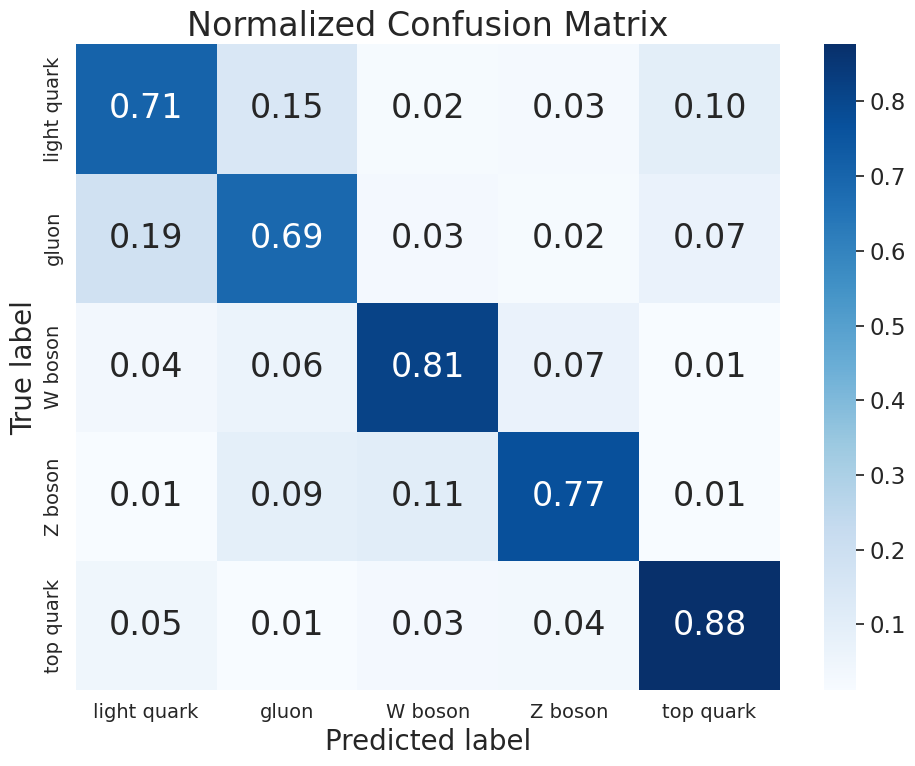

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Prepare data ---
(y_pred, y_true) = zip(*test_results)
y_pred = torch.stack(y_pred)
y_true = torch.stack(y_true)

# Convert one-hot to class indices
y_true_idx = [torch.argmax(y).item() for y in y_true]
y_pred_idx = [torch.argmax(y).item() for y in y_pred]

# --- Class names ---
class_names = ['light quark', 'gluon', 'W boson', 'Z boson', 'top quark']

# --- Compute confusion matrix ---
cm = confusion_matrix(y_true_idx, y_pred_idx, labels=range(len(class_names)))
cm_normalized = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

# --- Set font scale ---
sns.set(font_scale=1.5)  # Increase all font sizes

# --- Plot ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 24}  # Increase number font size in boxes
)

plt.xlabel("Predicted label", fontsize=20)
plt.ylabel("True label", fontsize=20)
plt.title("Normalized Confusion Matrix", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("NormalizedConfusion_plot1.png", dpi=300)
plt.show()

